In [1]:
!pip install kaggle
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 12.6 MB/s eta 0:00:00


In [ ]:
#upload api key
from google.colab import files
files.upload()

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json  # Set permissions


In [4]:
# Download dataset
!kaggle datasets download -d slavkoprytula/aquarium-data-cots


Dataset URL: https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots
License(s): CC0-1.0
 99% 66.0M/66.6M [00:03<00:00, 30.0MB/s]
100% 66.6M/66.6M [00:03<00:00, 18.8MB/s]


In [5]:
# Extract dataset
!unzip aquarium-data-cots.zip -d /content/aquarium_data/


Archive:  aquarium-data-cots.zip
  inflating: /content/aquarium_data/aquarium_pretrain/README.dataset.txt  
  inflating: /content/aquarium_data/aquarium_pretrain/README.roboflow.txt  
  inflating: /content/aquarium_data/aquarium_pretrain/data.yaml  
  inflating: /content/aquarium_data/aquarium_pretrain/test/images/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg  
  inflating: /content/aquarium_data/aquarium_pretrain/test/images/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg  
  inflating: /content/aquarium_data/aquarium_pretrain/test/images/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg  
  inflating: /content/aquarium_data/aquarium_pretrain/test/images/IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg  
  inflating: /content/aquarium_data/aquarium_pretrain/test/images/IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg  
  inflating: /content/aquarium_data/aquarium_pretrain/test/images/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.

In [8]:
import shutil
import os

# Create the directories if they don't exist
os.makedirs('/content/aquarium_data/images/train', exist_ok=True)
os.makedirs('/content/aquarium_data/images/val', exist_ok=True)
os.makedirs('/content/aquarium_data/labels/train', exist_ok=True)
os.makedirs('/content/aquarium_data/labels/val', exist_ok=True)

# Move images and labels (for example, 80% train, 20% val)
all_images = os.listdir('/content/aquarium_data/images/')
num_train = int(0.8 * len(all_images))  # 80% for training

train_images = all_images[:num_train]
val_images = all_images[num_train:]

# Move images to train and val folders
for img in train_images:
    shutil.move(f'/content/aquarium_data/images/{img}', f'/content/aquarium_data/images/train/{img}')
    # Move the corresponding label file if it exists
    label_file = f'/content/aquarium_data/labels/{img[:-4]}.txt'
    if os.path.exists(label_file):
        shutil.move(label_file, f'/content/aquarium_data/labels/train/{img[:-4]}.txt')

for img in val_images:
    shutil.move(f'/content/aquarium_data/images/{img}', f'/content/aquarium_data/images/val/{img}')
    # Move the corresponding label file if it exists
    label_file = f'/content/aquarium_data/labels/{img[:-4]}.txt'
    if os.path.exists(label_file):
        shutil.move(label_file, f'/content/aquarium_data/labels/val/{img[:-4]}.txt')


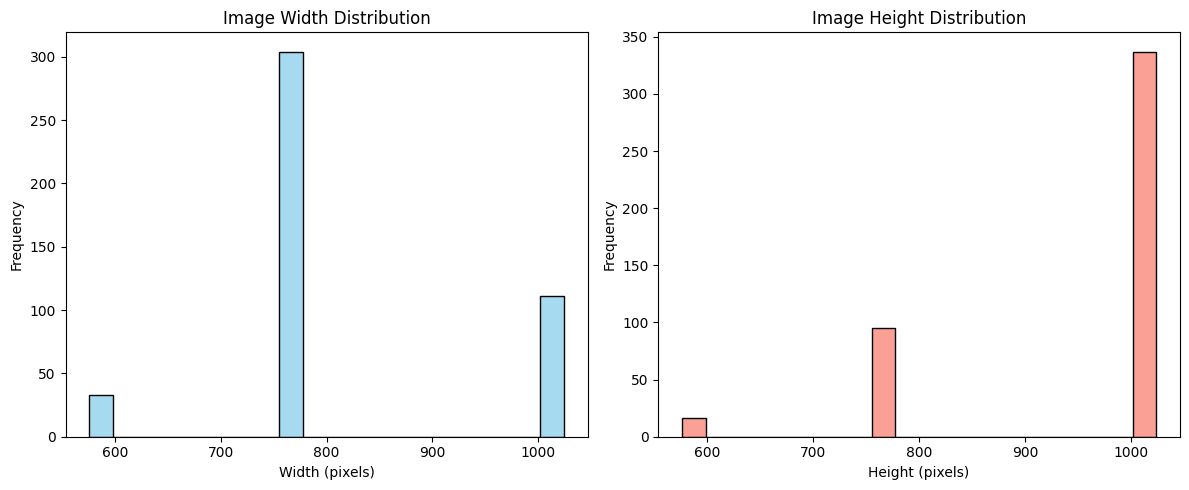

In [36]:
# Calculate image dimensions
image_dims = [(cv2.imread(str(img)).shape[1], cv2.imread(str(img)).shape[0]) for img in images_path.glob("*.jpg")]
widths, heights = zip(*image_dims)

# Plot width and height distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(widths, bins=20, ax=ax1, color="skyblue")
sns.histplot(heights, bins=20, ax=ax2, color="salmon")

ax1.set_title("Image Width Distribution")
ax1.set_xlabel("Width (pixels)")
ax1.set_ylabel("Frequency")

ax2.set_title("Image Height Distribution")
ax2.set_xlabel("Height (pixels)")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [9]:
# Create data.yaml File for YOLOv8
data_yaml = """
path: /content/aquarium_data/aquarium_pretrain
train: train/images  # Adjusted path for training images
val: val/images      # Adjust this path if you have a validation directory; otherwise, you may need to create it.

names:
  0: fish
  1: jellyfish
  2: penguin
  3: puffin
  4: shark
  5: starfish

"""
with open("aquarium_data/data.yaml", "w") as f:
    f.write(data_yaml)


In [11]:
import random
from glob import glob
import shutil

# Locate all images in the main dataset folder (adjust the path if necessary)
images = glob("aquarium_data/annotations/*/*")  # Replace with your extracted dataset path if different
random.shuffle(images)

train_split = int(0.8 * len(images))
train_images = images[:train_split]
val_images = images[train_split:]

# Move images to the appropriate folders
for img in train_images:
    shutil.move(img, "aquarium_data/images/train/")
for img in val_images:
    shutil.move(img, "aquarium_data/images/val/")


In [12]:
import os

# Check if the paths exist
print("Train directory:", os.path.isdir("aquarium_data/images/train"))
print("Val directory:", os.path.isdir("aquarium_data/images/val"))


Train directory: False
Val directory: True


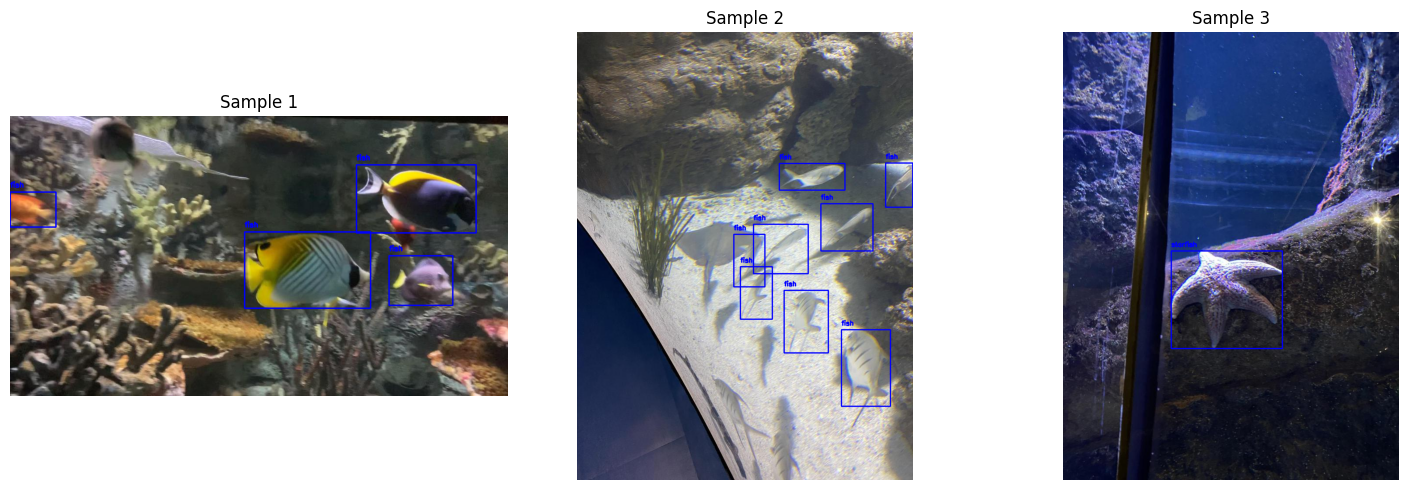

In [34]:
# Plot a few sample images with bounding boxes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, img_file in enumerate(random.sample(list(images_path.glob("*.jpg")), 3)):
    img = cv2.imread(str(img_file))
    label_file = labels_path / f"{img_file.stem}.txt"

    # Read the bounding box data
    with open(label_file, 'r') as f:
        for line in f.readlines():
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            class_id = int(class_id)

            # Check if class_id is within the valid range
            if class_id >= len(class_names):
                print(f"Warning: Invalid class_id {class_id} in label file {label_file}")
                continue  # Skip invalid labels

            # Convert normalized coordinates back to absolute image coordinates
            h, w = img.shape[:2]
            x_center, y_center = int(x_center * w), int(y_center * h)
            width, height = int(width * w), int(height * h)
            x1, y1 = int(x_center - width / 2), int(y_center - height / 2)
            x2, y2 = int(x_center + width / 2), int(y_center + height / 2)

            # Draw bounding box and label
            color = (255, 0, 0)  # Red bounding box color
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, class_names[class_id], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Plot image with bounding boxes
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].axis("off")
    axs[i].set_title(f"Sample {i + 1}")

plt.tight_layout()
plt.show()


In [13]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /content


In [14]:
!pip show ultralytics

Name: ultralytics
Version: 8.3.28
Summary: Ultralytics YOLO 🚀 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://ultralytics.com
Author: 
Author-email: Glenn Jocher <glenn.jocher@ultralytics.com>, Jing Qiu <jing.qiu@ultralytics.com>
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, torch, torchvision, tqdm, ultralytics-thop
Required-by: 


In [15]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # Load YOLOv8n pre-trained weights

# Start training
results = model.train(data="/content/aquarium_data/aquarium_pretrain/data.yaml",
                      epochs=30,
                      batch=16,
                      imgsz=640,
                      project="aquarium_yolo_training",
                      name="exp1")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 18.4MB/s]


Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/aquarium_data/aquarium_pretrain/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=aquarium_yolo_training, name=exp1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

100%|██████████| 755k/755k [00:00<00:00, 3.10MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/aquarium_data/aquarium_pretrain/train/labels... 448 images, 1 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<00:00, 1364.57it/s]

train: New cache created: /content/aquarium_data/aquarium_pretrain/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/aquarium_data/aquarium_pretrain/valid/labels... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<00:00, 1616.69it/s]

val: New cache created: /content/aquarium_data/aquarium_pretrain/valid/labels.cache


Plotting labels to aquarium_yolo_training/exp1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to aquarium_yolo_training/exp1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.543      3.723      1.299        199        640: 100%|██████████| 28/28 [06:11<00:00, 13.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.39s/it]

                   all        127        909     0.0139      0.553     0.0979     0.0544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      1.614      2.562      1.264        167        640: 100%|██████████| 28/28 [06:29<00:00, 13.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.70s/it]

                   all        127        909      0.363      0.046      0.171     0.0895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      1.568      2.282      1.268        116        640: 100%|██████████| 28/28 [06:17<00:00, 13.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.53s/it]

                   all        127        909      0.347      0.355      0.318      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      1.542       2.07      1.246        179        640: 100%|██████████| 28/28 [06:15<00:00, 13.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.90s/it]

                   all        127        909      0.353      0.357      0.318       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      1.563      1.944      1.264        221        640: 100%|██████████| 28/28 [06:14<00:00, 13.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.50s/it]

                   all        127        909      0.497      0.402      0.367      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.531      1.971      1.253        352        640: 100%|██████████| 28/28 [06:14<00:00, 13.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.93s/it]

                   all        127        909      0.513      0.468      0.469      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.496      1.769      1.241        346        640: 100%|██████████| 28/28 [06:15<00:00, 13.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.82s/it]

                   all        127        909      0.626      0.482       0.52      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      1.484      1.662      1.213        156        640: 100%|██████████| 28/28 [06:14<00:00, 13.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.97s/it]

                   all        127        909      0.439      0.385       0.38      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G       1.51       1.64       1.25        121        640: 100%|██████████| 28/28 [06:16<00:00, 13.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.87s/it]

                   all        127        909      0.554      0.521      0.519      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.447      1.564      1.204        215        640: 100%|██████████| 28/28 [06:16<00:00, 13.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.64s/it]

                   all        127        909      0.554      0.597      0.575      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.385      1.487      1.177        199        640: 100%|██████████| 28/28 [06:21<00:00, 13.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.79s/it]

                   all        127        909      0.625      0.542      0.602      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.406       1.46      1.198        201        640: 100%|██████████| 28/28 [06:14<00:00, 13.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.86s/it]

                   all        127        909      0.639       0.58      0.603       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.416      1.394      1.182        190        640: 100%|██████████| 28/28 [06:15<00:00, 13.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:40<00:00, 10.11s/it]

                   all        127        909      0.722      0.525      0.621      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      1.411      1.408      1.175        204        640: 100%|██████████| 28/28 [06:25<00:00, 13.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:40<00:00, 10.03s/it]

                   all        127        909       0.67       0.61      0.644      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.392      1.346      1.165        159        640: 100%|██████████| 28/28 [06:16<00:00, 13.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.56s/it]

                   all        127        909      0.664      0.602       0.64       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G       1.38      1.311      1.156        180        640: 100%|██████████| 28/28 [06:14<00:00, 13.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.43s/it]

                   all        127        909      0.721      0.614      0.687      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.367      1.276      1.156        246        640: 100%|██████████| 28/28 [06:15<00:00, 13.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.93s/it]

                   all        127        909      0.711       0.64      0.678      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G       1.32       1.22      1.133        250        640: 100%|██████████| 28/28 [06:18<00:00, 13.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:36<00:00,  9.12s/it]

                   all        127        909      0.731      0.657      0.682      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.323      1.227      1.135        229        640: 100%|██████████| 28/28 [06:12<00:00, 13.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.49s/it]

                   all        127        909      0.755      0.635      0.706      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.346      1.191      1.136        124        640: 100%|██████████| 28/28 [06:20<00:00, 13.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.45s/it]

                   all        127        909      0.755       0.62      0.681      0.397


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G       1.29      1.294      1.131        107        640: 100%|██████████| 28/28 [06:08<00:00, 13.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.60s/it]

                   all        127        909      0.745      0.597      0.669      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.264      1.232      1.122        142        640: 100%|██████████| 28/28 [06:08<00:00, 13.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.46s/it]

                   all        127        909      0.719      0.683      0.711      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      1.218      1.129      1.086        108        640: 100%|██████████| 28/28 [06:06<00:00, 13.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.60s/it]

                   all        127        909      0.761      0.646      0.732      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      1.218      1.118      1.094         80        640: 100%|██████████| 28/28 [06:05<00:00, 13.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.50s/it]

                   all        127        909      0.783      0.646       0.73      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      1.205      1.087        1.1         83        640: 100%|██████████| 28/28 [06:03<00:00, 12.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:36<00:00,  9.03s/it]

                   all        127        909      0.804      0.645      0.729      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.195      1.064      1.075         83        640: 100%|██████████| 28/28 [06:05<00:00, 13.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.37s/it]

                   all        127        909      0.819      0.647      0.738      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.193      1.042      1.092        100        640: 100%|██████████| 28/28 [06:05<00:00, 13.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.56s/it]

                   all        127        909      0.831      0.649      0.749      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      1.172      1.008      1.074        138        640: 100%|██████████| 28/28 [06:05<00:00, 13.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.37s/it]

                   all        127        909       0.82      0.663      0.744       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      1.164      1.012      1.056        152        640: 100%|██████████| 28/28 [06:06<00:00, 13.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:35<00:00,  8.83s/it]

                   all        127        909      0.839      0.658      0.746      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      1.161      1.002      1.059         96        640: 100%|██████████| 28/28 [06:04<00:00, 13.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.46s/it]

                   all        127        909      0.843      0.669      0.756      0.455



30 epochs completed in 3.438 hours.
Optimizer stripped from aquarium_yolo_training/exp1/weights/last.pt, 6.2MB
Optimizer stripped from aquarium_yolo_training/exp1/weights/best.pt, 6.2MB

Validating aquarium_yolo_training/exp1/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:31<00:00,  7.96s/it]


                   all        127        909      0.842       0.67      0.757      0.454
                  fish         63        459      0.843      0.673      0.786      0.452
             jellyfish          9        155      0.837      0.897      0.918      0.509
               penguin         17        104      0.765      0.627      0.689      0.314
                puffin         15         74       0.83      0.462      0.627      0.301
                 shark         28         57      0.883      0.614      0.714      0.479
              starfish         17         27      0.949      0.692      0.785      0.542
              stingray         23         33      0.783      0.727      0.779      0.581
Speed: 6.5ms preprocess, 218.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to aquarium_yolo_training/exp1


In [17]:
# Analyze Results
print("Training Complete.")
print(results)


Training Complete.
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee5b0d7dc60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.0460

In [27]:
# Analyze Results
metrics_dict = results.results_dict

# Print all available metrics for reference
print("Available metrics:", metrics_dict)

# Extract and print specific metrics using exact key names
precision = metrics_dict.get('metrics/precision(B)', 'Not available')
recall = metrics_dict.get('metrics/recall(B)', 'Not available')
map_50 = metrics_dict.get('metrics/mAP50(B)', 'Not available')  # mAP at 0.5 IoU threshold
map_50_95 = metrics_dict.get('metrics/mAP50-95(B)', 'Not available')  # mAP at 0.5-0.95 IoU threshold

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"mAP@0.5: {map_50}")
print(f"mAP@0.5-0.95: {map_50_95}")


Available metrics: {'metrics/precision(B)': 0.8415806902849042, 'metrics/recall(B)': 0.6703920687021988, 'metrics/mAP50(B)': 0.7567848469229517, 'metrics/mAP50-95(B)': 0.45392102403465945, 'fitness': 0.4842074063234887}
Precision: 0.8415806902849042
Recall: 0.6703920687021988
mAP@0.5: 0.7567848469229517
mAP@0.5-0.95: 0.45392102403465945


In [28]:
# Retrieve mean metrics across classes
mean_results = results.mean_results()

# Print mean precision, recall, and mAP if included in mean results
print("Mean results:", mean_results)


Mean results: [0.8415806902849042, 0.6703920687021988, 0.7567848469229517, 0.45392102403465945]


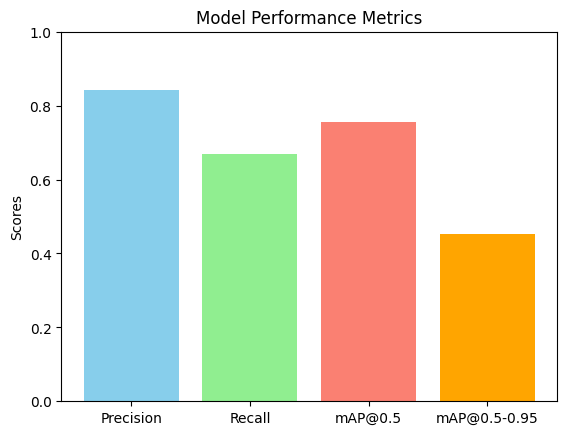

In [31]:
# Plot of model performance
import matplotlib.pyplot as plt

# Retrieve relevant metrics
precision = metrics_dict['metrics/precision(B)']
recall = metrics_dict['metrics/recall(B)']
map_50 = metrics_dict['metrics/mAP50(B)']
map_50_95 = metrics_dict['metrics/mAP50-95(B)']

# Plotting the metrics
fig, ax = plt.subplots()
metrics = ['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5-0.95']
values = [precision, recall, map_50, map_50_95]

# Create bar plot
ax.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'orange'])
ax.set_title("Model Performance Metrics")
ax.set_ylim(0, 1)  # assuming metrics are in range [0, 1]
ax.set_ylabel("Scores")

# Display plot
plt.show()


In [32]:
# Save the plot as an image file
fig.savefig("model_performance_metrics.png")
print("Plot saved as model_performance_metrics.png")


Plot saved as model_performance_metrics.png
